<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/delta_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount you Google drive to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/HumanData/utils')

In [4]:
!pip install librosa pydub snntorch tqdm matplotlib torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 9.4 MB/s eta 0:00:00


In [8]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary
from snntorch import surrogate, functional

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time
import itertools
import random
import json
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
from preprocessing import SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, DURATION
from preprocessing import (
    load_audio_file,
    naa,
    preprocess_audio,
    batch_logmel,
    pad_to_multiple_of,
    preprocess_dataset
)

from spike_encoding import (
    DeltaAudioDataset,
    ThresholdAdaptiveDataset,
    StepForwardDataset,
    visualize_spike_trains
)

from train_eval import (
    train_fn,
    evaluate_model_comprehensive
)

from models import (
    SNNClassifier,
    C_SNN
)

In [9]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [10]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [26]:
# Labels ESC-10
class ESCLabels:
    class_names = [
        'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
        'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
    ]
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}


In [12]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100
DURATION = 5.0

In [15]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [04:02<00:00, 24.25s/it]


In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


# Preprocessing



In [17]:
X_train_tensor, y_train_tensor = preprocess_dataset(X_train, y_train, apply_naa=True, apply_taa=True)
X_val_tensor, y_val_tensor = preprocess_dataset(X_val, y_val, apply_naa=False, apply_taa=False)
X_test_tensor, y_test_tensor = preprocess_dataset(X_test, y_test, apply_naa=False, apply_taa=False)

Log-Mel: 100%|██████████| 80/80 [00:02<00:00, 26.85it/s]


Shape verification

In [18]:
print("X_train:", X_train_tensor.shape, "| y_train:", y_train_tensor.shape)
print("X_val:  ", X_val_tensor.shape, "| y_val:  ", y_val_tensor.shape)
print("X_test: ", X_test_tensor.shape, "| y_test: ", y_test_tensor.shape)

X_train: torch.Size([6000, 128, 900, 1]) | y_train: torch.Size([6000])
X_val:   torch.Size([80, 128, 900, 1]) | y_val:   torch.Size([80])
X_test:  torch.Size([80, 128, 900, 1]) | y_test:  torch.Size([80])


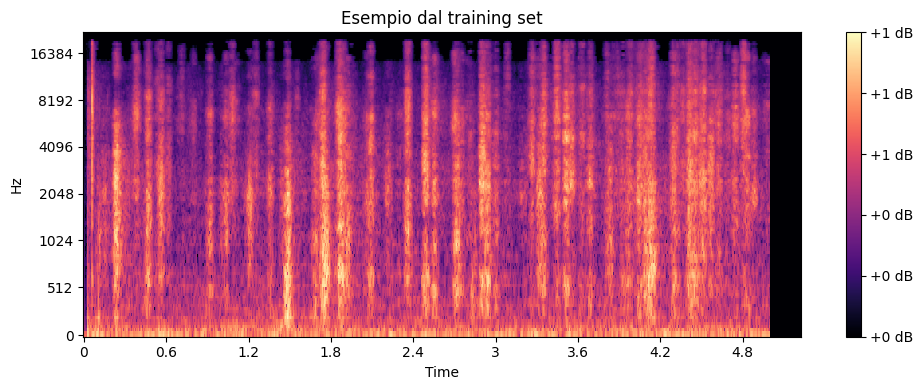

Class: crackling_fire


In [27]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_tensor[sample_idx], title="Esempio dal training set")
print("Class:", ESCLabels.index_to_label[y_train_tensor[sample_idx].item()])


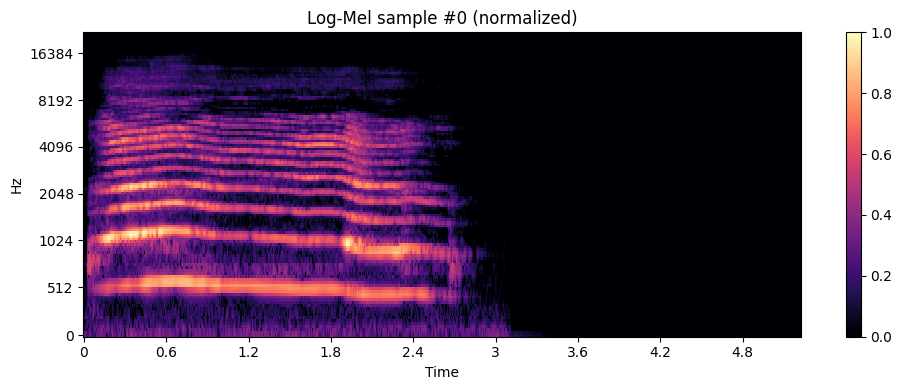

Class: crackling_fire


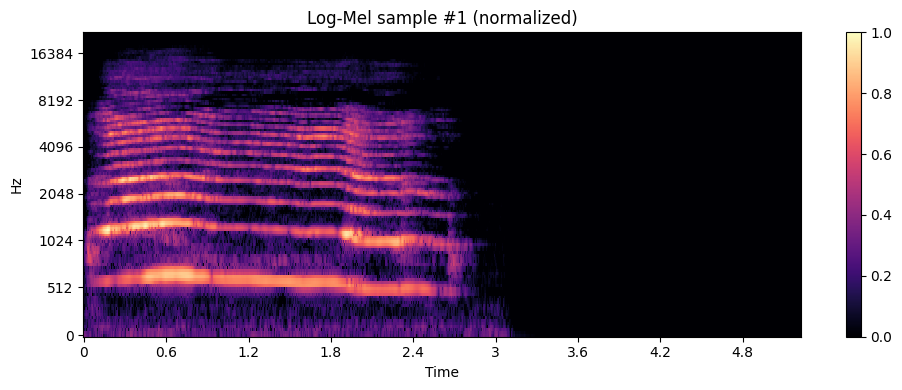

Class: crackling_fire


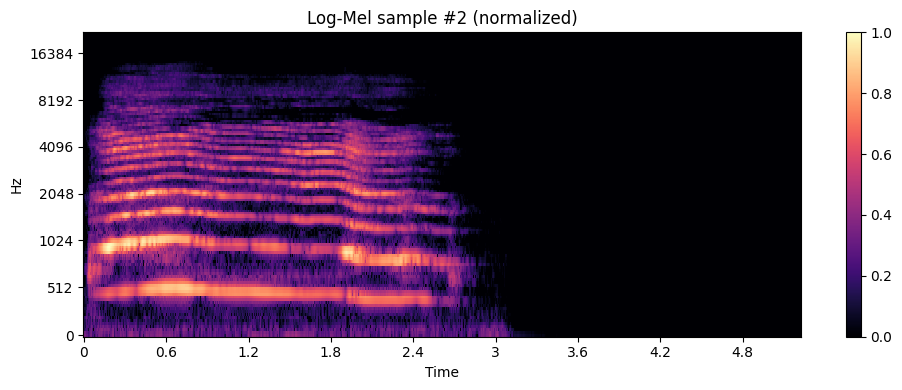

Class: crackling_fire


In [29]:
def show_mel_sample(index):
    mel = X_train_tensor[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels.index_to_label[y_train_tensor[sample_idx].item()])

for i in range(3):
    show_mel_sample(i)

# Spike Encoding: Delta Modulation

In [30]:
BATCH_SIZE = 32
THRESHOLD = 0.05
TIMESTEPS = 200

In [38]:
delta_train_dataset = DeltaAudioDataset(X_train_tensor, y_train_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_val_dataset = DeltaAudioDataset(X_val_tensor, y_val_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_test_dataset = DeltaAudioDataset(X_test_tensor, y_test_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)

In [39]:
delta_train_loader = DataLoader(delta_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
delta_val_loader = DataLoader(delta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
delta_test_loader = DataLoader(delta_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [40]:
X_batch, y_batch = next(iter(delta_train_loader))
print("DeltaModulation encoding compleated!")

DeltaModulation encoding compleated!


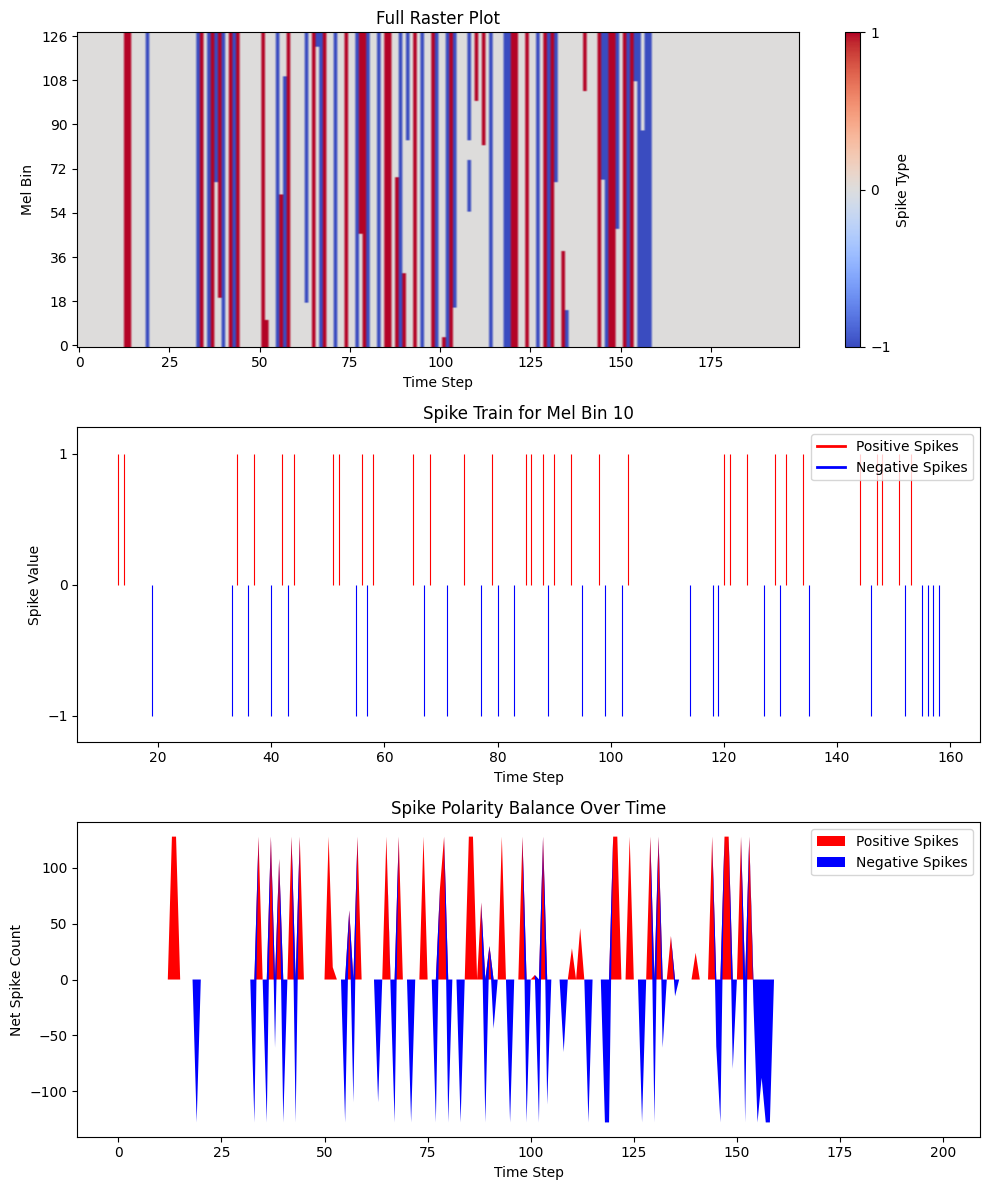

Classe: 3


In [41]:
sample_idx = 2
visualize_spike_trains(X_batch, sample_idx=sample_idx, mel_bin=10)
print("Classe:", y_batch[sample_idx].item())

##Delta Modulation: SNN training

In [44]:
hidden_sizes = [128, 128, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [ ]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True
)

Epochs:   1%|          | 1/100 [03:41<6:05:21, 221.43s/it]


Epoch 1/100 - 221s - loss: 2.3040 - acc: 0.1069 - val_loss: 2.2920 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [07:19<5:58:14, 219.33s/it]


Epoch 2/100 - 217s - loss: 2.3103 - acc: 0.1267 - val_loss: 2.3043 - val_acc: 0.1354



Epochs:   3%|▎         | 3/100 [10:57<5:53:42, 218.79s/it]


Epoch 3/100 - 218s - loss: 2.3554 - acc: 0.1697 - val_loss: 2.0506 - val_acc: 0.2917



Epochs:   4%|▍         | 4/100 [14:32<5:47:26, 217.15s/it]


Epoch 4/100 - 214s - loss: 2.2783 - acc: 0.2304 - val_loss: 1.8758 - val_acc: 0.3229



Epochs:   5%|▌         | 5/100 [18:26<5:53:34, 223.31s/it]


Epoch 5/100 - 234s - loss: 2.2157 - acc: 0.2570 - val_loss: 2.0599 - val_acc: 0.4375



Train batches:  30%|██▉       | 56/188 [00:59<02:03,  1.07it/s]

##Delta Modulation: SNN evaluation

In [ ]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_snn_delta = evaluate_model_comprehensive(snn_classifier, delta_test_loader, ESCLabels.class_names, device)

##Delta Modulation: SCNN training

In [ ]:
c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=8,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

In [ ]:
patience = 30
num_epochs = 100
optimizer = torch.optim.Adam(c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=c_snn_model,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

In [ ]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
results_scnn_delta = evaluate_model_comprehensive(c_snn_model, delta_test_loader, ESCLabels.class_names, device)

# Spike Encoding: Threshold Adaptive Encoding

In [ ]:
ALPHA = 0.999

In [ ]:
tae_train_dataset = ThresholdAdaptiveDataset(X_train_tensor, y_train_tensor, alpha=ALPHA)
tae_val_dataset = ThresholdAdaptiveDataset(X_val_tensor, y_val_tensor, alpha=ALPHA)
tae_test_dataset = ThresholdAdaptiveDataset(X_test_tensor, y_test_tensor, alpha=ALPHA)

In [ ]:
tae_train_loader = DataLoader(tae_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
tae_val_loader = DataLoader(tae_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
tae_test_loader = DataLoader(tae_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())